The [Phoible](https://phoible.org/) dataset contains phoneme inventories for thousands of languages and dialects. Many languages/dialicts have multiple Phoible records. Here, I'm mapping the data against pre-prepared IPA phoneme tables, then selecting one sample per table per language so that each language is only represented once in the final dataset (to avoid bias by oversampling).

The IPA phoneme tables contain some phonemes with diacritics and some without. They seem to include only 0 or 1 diacritic perphoneme. 

The Phoible data also contains phonemes with and without diacritics, but they may contain sequences of multiple diacritics after each phoneme. These need to be split and handled seperately.



In [38]:
from pathlib import Path
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display


phoible_data_url = "https://raw.githubusercontent.com/phoible/dev/v2.0/data/phoible.csv"
phobile_file_path = "./downloads/phoible.csv"

VALIDATE_RESULTS = True

if not Path(phobile_file_path).exists():
    response = requests.get(phoible_data_url, stream=True)

    with open(phobile_file_path, "wb") as fh:
        for data in tqdm(response.iter_content()):
            fh.write(data)

In [39]:
ipa_diacritics_df = pd.read_csv(
    "./data/ipa_diacritics.csv", dtype=str, encoding="utf-8", engine="python"
)
ipa_diacritics_df["unicode"] = ipa_diacritics_df.suffix.apply(lambda x: hex(ord(x)))
valid_diacritics = ipa_diacritics_df.suffix
display(ipa_diacritics_df)
ipa_diacritics_df.shape

,suffix,description,unicode
0,,Standard,0x20
1,ː,Long,0x2d0
2,ˑ,Half-long,0x2d1
3,̥,Voiceless,0x325
4,̊,Voiceless,0x30a
5,̬,Voiced,0x32c
6,ʰ,Aspirated,0x2b0
7,̹,More rounded,0x339
8,̜,Less rounded,0x31c
9,̟,Advanced,0x31f


(38, 3)

Load the Phoible data and split the IPA diacritic suffixes from all phonemes so the raw phoneme can be matched against the pre-prepared IPA phoneme tables.

In [40]:
phoible_df = pd.read_csv(phobile_file_path, encoding="utf-8", engine="python")
dialect_phonemes_df = (
    phoible_df[["ISO6393", "LanguageName", "SpecificDialect", "Phoneme"]]
    .copy()
    .fillna({"SpecificDialect": "none"})
)


def split_symbol(phoneme):
    return "".join([x for x in list(phoneme) if x not in valid_diacritics.values])


def split_diacritics(phoneme):
    return "".join([x for x in list(phoneme) if x in valid_diacritics.values])


def split_dialect_phoneme_diacritics(df):
    df["symbol"] = df.Phoneme.apply(split_symbol)
    df["diacritics"] = df.Phoneme.apply(split_diacritics)
    df.loc[df.diacritics.str.len() == 0, "diacritics"] = " "
    df["versions"] = df.diacritics.apply(
        lambda d: ",".join(valid_diacritics.isin(list(d)).astype(int).astype(str))
    )
    return df


dialect_phonemes_df = split_dialect_phoneme_diacritics(dialect_phonemes_df)

print(dialect_phonemes_df.shape)
dialect_phonemes_df.head(3)

(105467, 7)


,ISO6393,LanguageName,SpecificDialect,Phoneme,symbol,diacritics,versions
0,kor,Korean,none,a,a,,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,kor,Korean,none,aː,a,ː,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,kor,Korean,none,æ,æ,,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [41]:
lang_by_dialect_df = dialect_phonemes_df.groupby(
    ["LanguageName", "SpecificDialect"]
)

Load the pre-prepared IPA tables.

In [42]:
cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_pl_tbl_df)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_npl_tbl_df)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_coart_tbl_df)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(vowels_tbl_df)


cons_pl_tbl_shape = [*cons_pl_tbl_df.shape]
cons_npl_tbl_shape = [*cons_npl_tbl_df.shape]
cons_coart_tbl_shape = [*cons_coart_tbl_df.shape]
vowels_tbl_shape = [*vowels_tbl_df.shape]

cons_pl_tbl_shape, cons_npl_tbl_shape, cons_coart_tbl_shape, vowels_tbl_shape

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Dental,Dental_v,Alveolar,Alveolar_v,Postalveolar,Postalveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Plosive,p,b,,,t̪,d̪,t,d,,,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Nasal,,m,,ɱ,,n̪,,n,,,...,,ɲ,,ŋ,,ɴ,NaN,NaN,NaN,NaN
Trill,,ʙ,,,,r̪,,r,,,...,,,NaN,NaN,,ʀ,,,NaN,NaN
Tap or Flap,,,,ⱱ,,ɾ̪,,ɾ,,,...,,,NaN,NaN,,,,,NaN,NaN
Fricative,ɸ,β,f,v,θ,ð,s,z,ʃ,ʒ,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Lateral fricative,NaN,NaN,NaN,NaN,,,ɬ,ɮ,,,...,,,,,,,NaN,NaN,NaN,NaN
Approximant,,,,ʋ,,,,ɹ,,,...,,j,,ɰ,,,,,NaN,NaN
Lateral approximant,NaN,NaN,NaN,NaN,,l̪,,l,,,...,,ʎ,,ʟ,,,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7
Ejective Stop,pʼ,tʼ,ʈʼ,cʼ,kʼ,qʼ,ʡʼ,
Ejective Fricative,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ
Ejective Affricate,tsʼ,t̠ʃʼ,ʈʂʼ,kxʼ,qχʼ,,,
Ejective Lateral,ɬʼ,tɬʼ,cʎ̝̊ʼ,kʟ̝̊ʼ,,,,
Click,kʘ,kǀ,kǃ,kǂ,kǁ,,,
Implosive Voiced,ɓ,ɗ,ᶑ,ʄ,ɠ,ʛ,,
Implosive Voiceless,ɓ̥,ɗ̥,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,,


,Labial–alveolar,Labial–alveolar_v,Labial–retroflex,Labial–retroflex_v,Labial–palatal,Labial–palatal_v,Labial–velar,Labial–velar_v,Labial–uvular,Labial–uvular_v,Velarized alveolar,Velarized alveolar_v,Uvular–epiglottal,Uvular–epiglottal_v,Palatal-velar,Palatal-velar_v
Nasal,,n͡m,,ɳ͡m,,,,ŋ͡m,,,,,,,,
Plosive,t͡p,d͡b,ʈ͡p,ɖ͡b,,,k͡p,ɡ͡b,q͡p,,,,q͡ʡ,,,
Fricative/approximant,,,,,ɥ̊,ɥ,ʍ,w,,,,,,,ɧ,
Lateral approximant,,,,,,,,,,,,ɫ,,,,
Implosive,,,,,,,ɠ̊͜ɓ̥,ɠ͡ɓ,,,,,,,,
Ejective,,t͡pʼ,,,,,,,,,,,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


([8, 22], [7, 8], [6, 16], [7, 10])

Convert the IPA tables to Numpy arrays for use later.

In [43]:
def map_tbl_phoneme(phoneme):
    chars = list(phoneme)
    symbols = [x for x in chars if x not in valid_diacritics.values]
    diacritics = [x for x in chars if x in valid_diacritics.values]
    return np.array([phoneme, "".join(symbols), "".join(diacritics)])

cons_pl_tbl_npy = np.array(
    [map_tbl_phoneme(phoneme) for phoneme in cons_pl_tbl_df.fillna("").stack()]
)
cons_npl_tbl_npy = np.array(
    [map_tbl_phoneme(phoneme) for phoneme in cons_npl_tbl_df.fillna("").stack()]
)
cons_coart_tbl_npy = np.array(
    [map_tbl_phoneme(phoneme) for phoneme in cons_coart_tbl_df.fillna("").stack()]
)
vowels_tbl_npy = np.array(
    [map_tbl_phoneme(phoneme) for phoneme in vowels_tbl_df.fillna("").stack()]
)

# print a sample
cons_pl_tbl_npy[0], cons_npl_tbl_npy[0], cons_coart_tbl_npy[0], vowels_tbl_npy[0]

(array(['p', 'p', ''], dtype='<U2'),
 array(['pʼ', 'p', 'ʼ'], dtype='<U5'),
 array(['', '', ''], dtype='<U5'),
 array(['i', 'i', ''], dtype='<U2'))

In [44]:
# do we have duplicates?

all_table_entries = np.concatenate(
    [
        cons_pl_tbl_npy,
        cons_npl_tbl_npy,
        cons_coart_tbl_npy,
        vowels_tbl_npy,
    ]
)

table_phonemes = all_table_entries[all_table_entries[:, 0] != ""]

unique_phonemes, table_phonemes_counts = np.unique(
    table_phonemes[:, 0], return_counts=True
)

assert np.max(table_phonemes_counts) == 1

table_phonemes[0:3]

array([['p', 'p', ''],
       ['b', 'b', ''],
       ['t̪', 't', '̪']], dtype='<U5')

In [45]:
# stack and split tables to seperate phonemes with/without specific diacritics

table_phonemes_with_diacritics = (
    table_phonemes[np.char.str_len(table_phonemes[:, 2]) > 0]
)
table_phonemes_without_diacritics = table_phonemes[
    np.char.str_len(table_phonemes[:, 2]) == 0
]

table_phonemes_with_diacritics[0:3], table_phonemes_without_diacritics[0:3]

(array([['t̪', 't', '̪'],
        ['d̪', 'd', '̪'],
        ['n̪', 'n', '̪']], dtype='<U5'),
 array([['p', 'p', ''],
        ['b', 'b', ''],
        ['t', 't', '']], dtype='<U5'))

For each langauge dialect, map all 4 phoneme tables against all the phonemes in the dialect.

If the table phoneme has a diacritic mark, compare the language phoneme and table phoneme directly. Return an array with one phoneme variant indicated for each matching table phoneme.

If the table phoneme doesn't have a diacritic mark, compare the base symbol of the language phoneme against the table phoneme. Return an array with all phoneme variants indicated for each matching table phoneme.

If the table cell is empty, return an array of zeros (length matching the number of phoneme variants) 

In [46]:
# combine duplicate phonemes that don't have explicit diacritic handling
# in one of the tables

handled_phonemes_df = dialect_phonemes_df[
    dialect_phonemes_df.Phoneme.isin(table_phonemes_with_diacritics[:, 0])
]


def merge_versions(versions):
    arr = np.array([[int(n) for n in v.split(",")] for v in versions])
    return ",".join(np.max(arr, axis=0).astype(str))


unhandled_phonemes_df = (
    dialect_phonemes_df[
        ~dialect_phonemes_df.Phoneme.isin(table_phonemes_with_diacritics[:, 0])
    ][
        [
            "ISO6393",
            "LanguageName",
            "SpecificDialect",
            "symbol",
            "diacritics",
            "versions",
        ]
    ]
    .groupby(["ISO6393", "LanguageName", "SpecificDialect", "symbol"])
    .agg({"diacritics": "".join, "versions": merge_versions})
    .reset_index()
)
unhandled_phonemes_df["Phoneme"] = unhandled_phonemes_df.symbol
unhandled_phonemes_df = unhandled_phonemes_df[
    [
        "ISO6393",
        "LanguageName",
        "SpecificDialect",
        "Phoneme",
        "symbol",
        "diacritics",
        "versions",
    ]
]


phonemes_to_process_df = pd.concat(
    [handled_phonemes_df, unhandled_phonemes_df]
).reset_index(drop=True)


print("dialect_phonemes_df", dialect_phonemes_df.shape)
print("handled_phonemes_df", handled_phonemes_df.shape)
print("unhandled_phonemes_df", unhandled_phonemes_df.shape)
print("phonemes_to_process_df", phonemes_to_process_df.shape)
display(handled_phonemes_df.head(3))
display(unhandled_phonemes_df.head(3))
display(phonemes_to_process_df.head(3))

dialect_phonemes_df (105467, 7)
handled_phonemes_df (3669, 7)
unhandled_phonemes_df (80029, 7)
phonemes_to_process_df (83698, 7)


,ISO6393,LanguageName,SpecificDialect,Phoneme,symbol,diacritics,versions
91,lbe,Lak,none,kʼ,k,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
98,lbe,Lak,none,pʼ,p,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
104,lbe,Lak,none,qʼ,q,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


,ISO6393,LanguageName,SpecificDialect,Phoneme,symbol,diacritics,versions
0,aae,Arbëresh Albanian,Arbëresh Albanian (Hora e Arbëreshëvet),a,a,,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,aae,Arbëresh Albanian,Arbëresh Albanian (Hora e Arbëreshëvet),b,b,,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,aae,Arbëresh Albanian,Arbëresh Albanian (Hora e Arbëreshëvet),c,c,,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


,ISO6393,LanguageName,SpecificDialect,Phoneme,symbol,diacritics,versions
0,lbe,Lak,none,kʼ,k,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,lbe,Lak,none,pʼ,p,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,lbe,Lak,none,qʼ,q,ʼ,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [47]:
phonemes_to_process_by_dialect_df = phonemes_to_process_df.groupby(
    ["LanguageName", "SpecificDialect"]
)

language_names_and_dialects = (
    phonemes_to_process_by_dialect_df.first().index.to_frame().reset_index(drop=True)
)

display(language_names_and_dialects.head(5))
num_lang = len(language_names_and_dialects)

print("num_lang", num_lang)

,LanguageName,SpecificDialect
0,!XU,none
1,!Xóõ,none
2,!Xun,W2
3,ABIPON,none
4,ACHE,none


num_lang 2934


In [48]:
def create_symbol_matrix(phoneme_tbl):
    zeros = np.zeros((phoneme_tbl.shape[0], valid_diacritics.shape[0])).astype(int)

    phoneme_tbl_df = pd.DataFrame(
        phoneme_tbl,
        columns=["Phoneme", "symbol", "diacritics"],
        dtype=str,
    )

    def map_table(dialect_df):
        # this should return a matrix of shape (*phoneme_tbl.shape, valid_diacritics.shape[0])
        mappings = phoneme_tbl_df.merge(
            dialect_df[dialect_df.diacritics.str.len() == 1][
                ["Phoneme", "versions"]
            ].drop_duplicates(),
            how="left",
            on="Phoneme",
            validate="m:1",
        ).merge(
            dialect_df[dialect_df.diacritics.str.len() != 1][["symbol", "versions"]]
            .groupby(["symbol"])
            .agg({"versions": merge_versions}),
            how="left",
            on="symbol",
            validate="m:1",
        )

        mappings.loc[mappings.versions_x.isna(), "versions_x"] = ",".join(
            np.zeros(valid_diacritics.shape[0]).astype(int).astype(str)
        )

        mappings.loc[mappings.versions_y.isna(), "versions_y"] = ",".join(
            np.zeros(valid_diacritics.shape[0]).astype(int).astype(str)
        )

        mappings = mappings.to_numpy()

        is_handled = np.isin(mappings[:, 0], dialect_df.Phoneme.values) & ~np.isin(
            mappings[:, 1], dialect_df.symbol.values
        )
        is_unhandled = ~np.isin(mappings[:, 0], dialect_df.Phoneme.values) & np.isin(
            mappings[:, 1], dialect_df.symbol.values
        )

        is_handled_reshaped = np.repeat(
            is_handled[:, None], valid_diacritics.shape[0], axis=1
        )

        is_unhandled_reshaped = np.repeat(
            is_unhandled[:, None], valid_diacritics.shape[0], axis=1
        )

        handled_resuts = np.where(
            is_handled_reshaped,
            np.array(
                [[int(x) for x in versions.split(",")] for versions in mappings[:, 3]]
            ),
            zeros.copy(),
        )
        unhandled_resuts = np.where(
            is_unhandled_reshaped,
            np.array(
                [[int(x) for x in versions.split(",")] for versions in mappings[:, 4]]
            ),
            zeros.copy(),
        )

        return np.where(handled_resuts, handled_resuts, unhandled_resuts)

    return map_table


cons_pl_processed = np.stack(
    phonemes_to_process_by_dialect_df.apply(
        create_symbol_matrix(cons_pl_tbl_npy), include_groups=False
    ).to_numpy()
)
cons_npl_processed = np.stack(
    phonemes_to_process_by_dialect_df.apply(
        create_symbol_matrix(cons_npl_tbl_npy), include_groups=False
    ).to_numpy()
)
cons_coart_processed = np.stack(
    phonemes_to_process_by_dialect_df.apply(
        create_symbol_matrix(cons_coart_tbl_npy), include_groups=False
    ).to_numpy()
)
vowels_processed = np.stack(
    phonemes_to_process_by_dialect_df.apply(
        create_symbol_matrix(vowels_tbl_npy), include_groups=False
    ).to_numpy()
)


(
    cons_pl_processed.shape,
    cons_npl_processed.shape,
    cons_coart_processed.shape,
    vowels_processed.shape,
)

((2934, 176, 38), (2934, 56, 38), (2934, 96, 38), (2934, 70, 38))

In [49]:
unique_names = np.unique(language_names_and_dialects.LanguageName)
language_names_and_dialects.shape, unique_names.shape

((2934, 2), (2727,))

In [50]:
cons_pl_selected = np.array(
    [np.max(cons_pl_processed[language_names_and_dialects.LanguageName == name], axis=0) for name in unique_names]
)
cons_npl_selected = np.array(
    [
        np.max(cons_npl_processed[language_names_and_dialects.LanguageName == name], axis=0)
        for name in unique_names
    ]
)
cons_coart_selected = np.array(
    [
        np.max(cons_coart_processed[language_names_and_dialects.LanguageName == name], axis=0)
        for name in unique_names
    ]
)
vowels_selected = np.array(
    [np.max(vowels_processed[language_names_and_dialects.LanguageName == name], axis=0) for name in unique_names]
)

# sense check
for name in unique_names:
    assert (
        cons_pl_processed[language_names_and_dialects.LanguageName == name].shape[1:]
        == cons_pl_selected.shape[1:]
    )
    assert (
        cons_npl_processed[language_names_and_dialects.LanguageName == name].shape[1:]
        == cons_npl_selected.shape[1:]
    )
    assert (
        cons_coart_processed[language_names_and_dialects.LanguageName == name].shape[1:]
        == cons_coart_selected.shape[1:]
    )
    assert (
        vowels_processed[language_names_and_dialects.LanguageName == name].shape[1:] == vowels_selected.shape[1:]
    )

(
    cons_pl_selected.shape,
    cons_npl_selected.shape,
    vowels_selected.shape,
    cons_coart_selected.shape,
)

((2727, 176, 38), (2727, 56, 38), (2727, 70, 38), (2727, 96, 38))

In [51]:
# reshape the stacked tables to their original 2D shape
# and convert the phoneme versions array (len 38)
# to 4 numbers to use as rgb channels by extending the 
# array to 39, splitting in to 3 arrays of 13, converting
# each array to a binary (8191), and normalising (0-1)
cons_pl_selected = np.apply_along_axis(
    lambda b: b.dot(2 ** np.arange(b.size)[::-1]) / 8191,
    4,
    np.dstack([cons_pl_selected, np.zeros((*cons_pl_selected.shape[0:2], 1))]).reshape(
        (cons_pl_selected.shape[0], *cons_pl_tbl_shape, 3, -1)
    ),
)
cons_npl_selected = np.apply_along_axis(
    lambda b: b.dot(2 ** np.arange(b.size)[::-1]) / 8191,
    4,
    np.dstack(
        [cons_npl_selected, np.zeros((*cons_npl_selected.shape[0:2], 1))]
    ).reshape((cons_npl_selected.shape[0], *cons_npl_tbl_shape, 3, -1)),
)
cons_coart_selected = np.apply_along_axis(
    lambda b: b.dot(2 ** np.arange(b.size)[::-1]) / 8191,
    4,
    np.dstack(
        [cons_coart_selected, np.zeros((*cons_coart_selected.shape[0:2], 1))]
    ).reshape((cons_coart_selected.shape[0], *cons_coart_tbl_shape, 3, -1)),
)
vowels_selected = np.apply_along_axis(
    lambda b: b.dot(2 ** np.arange(b.size)[::-1]) / 8191,
    4,
    np.dstack([vowels_selected, np.zeros((*vowels_selected.shape[0:2], 1))]).reshape(
        (vowels_selected.shape[0], *vowels_tbl_shape, 3, -1)
    ),
)

(
    cons_pl_selected.shape,
    cons_npl_selected.shape,
    cons_coart_selected.shape,
    vowels_selected.shape,
)

((2727, 8, 22, 3), (2727, 7, 8, 3), (2727, 6, 16, 3), (2727, 7, 10, 3))

In [52]:
np.save("./data/consonants_plumonic.npy", cons_pl_selected)
np.save("./data/consonants_non_plumonic.npy", cons_npl_selected)
np.save("./data/consonants_coarticulated.npy", cons_coart_selected)
np.save("./data/vowels.npy", vowels_selected)

Merge all the data into a single 4d array. Each language is represented by a 3d matrix, with values from the 4 IPA table types stacked vertically with a padding row between each group.

In [53]:
max_cols = max(
    cons_pl_selected.shape[2],
    cons_npl_selected.shape[2],
    cons_coart_selected.shape[2],
    vowels_selected.shape[2],
)
max_value = max(
    np.max(cons_pl_selected),
    np.max(cons_npl_selected),
    np.max(cons_coart_selected),
    np.max(vowels_selected),
)


def get_padding(arr, max_cols):
    return ((0, 0), (0, 0), (0, max_cols - arr.shape[2]), (0, 0))


language_phonemes_selected = np.hstack(
    [
        np.pad(
            cons_pl_selected,
            get_padding(cons_pl_selected, max_cols),
            mode="constant",
        ),
        np.full((cons_pl_selected.shape[0], 1, max_cols, 3), 0.1),
        np.pad(
            cons_npl_selected,
            get_padding(cons_npl_selected, max_cols),
            mode="constant",
        ),
        np.full((cons_pl_selected.shape[0], 1, max_cols, 3), 0.1),
        np.pad(
            cons_coart_selected,
            get_padding(cons_coart_selected, max_cols),
            mode="constant",
        ),
        np.full((cons_pl_selected.shape[0], 1, max_cols, 3), 0.1),
        np.pad(
            vowels_selected, get_padding(vowels_selected, max_cols), mode="constant"
        ),
    ]
)

language_phonemes_selected.shape

(2727, 31, 22, 3)

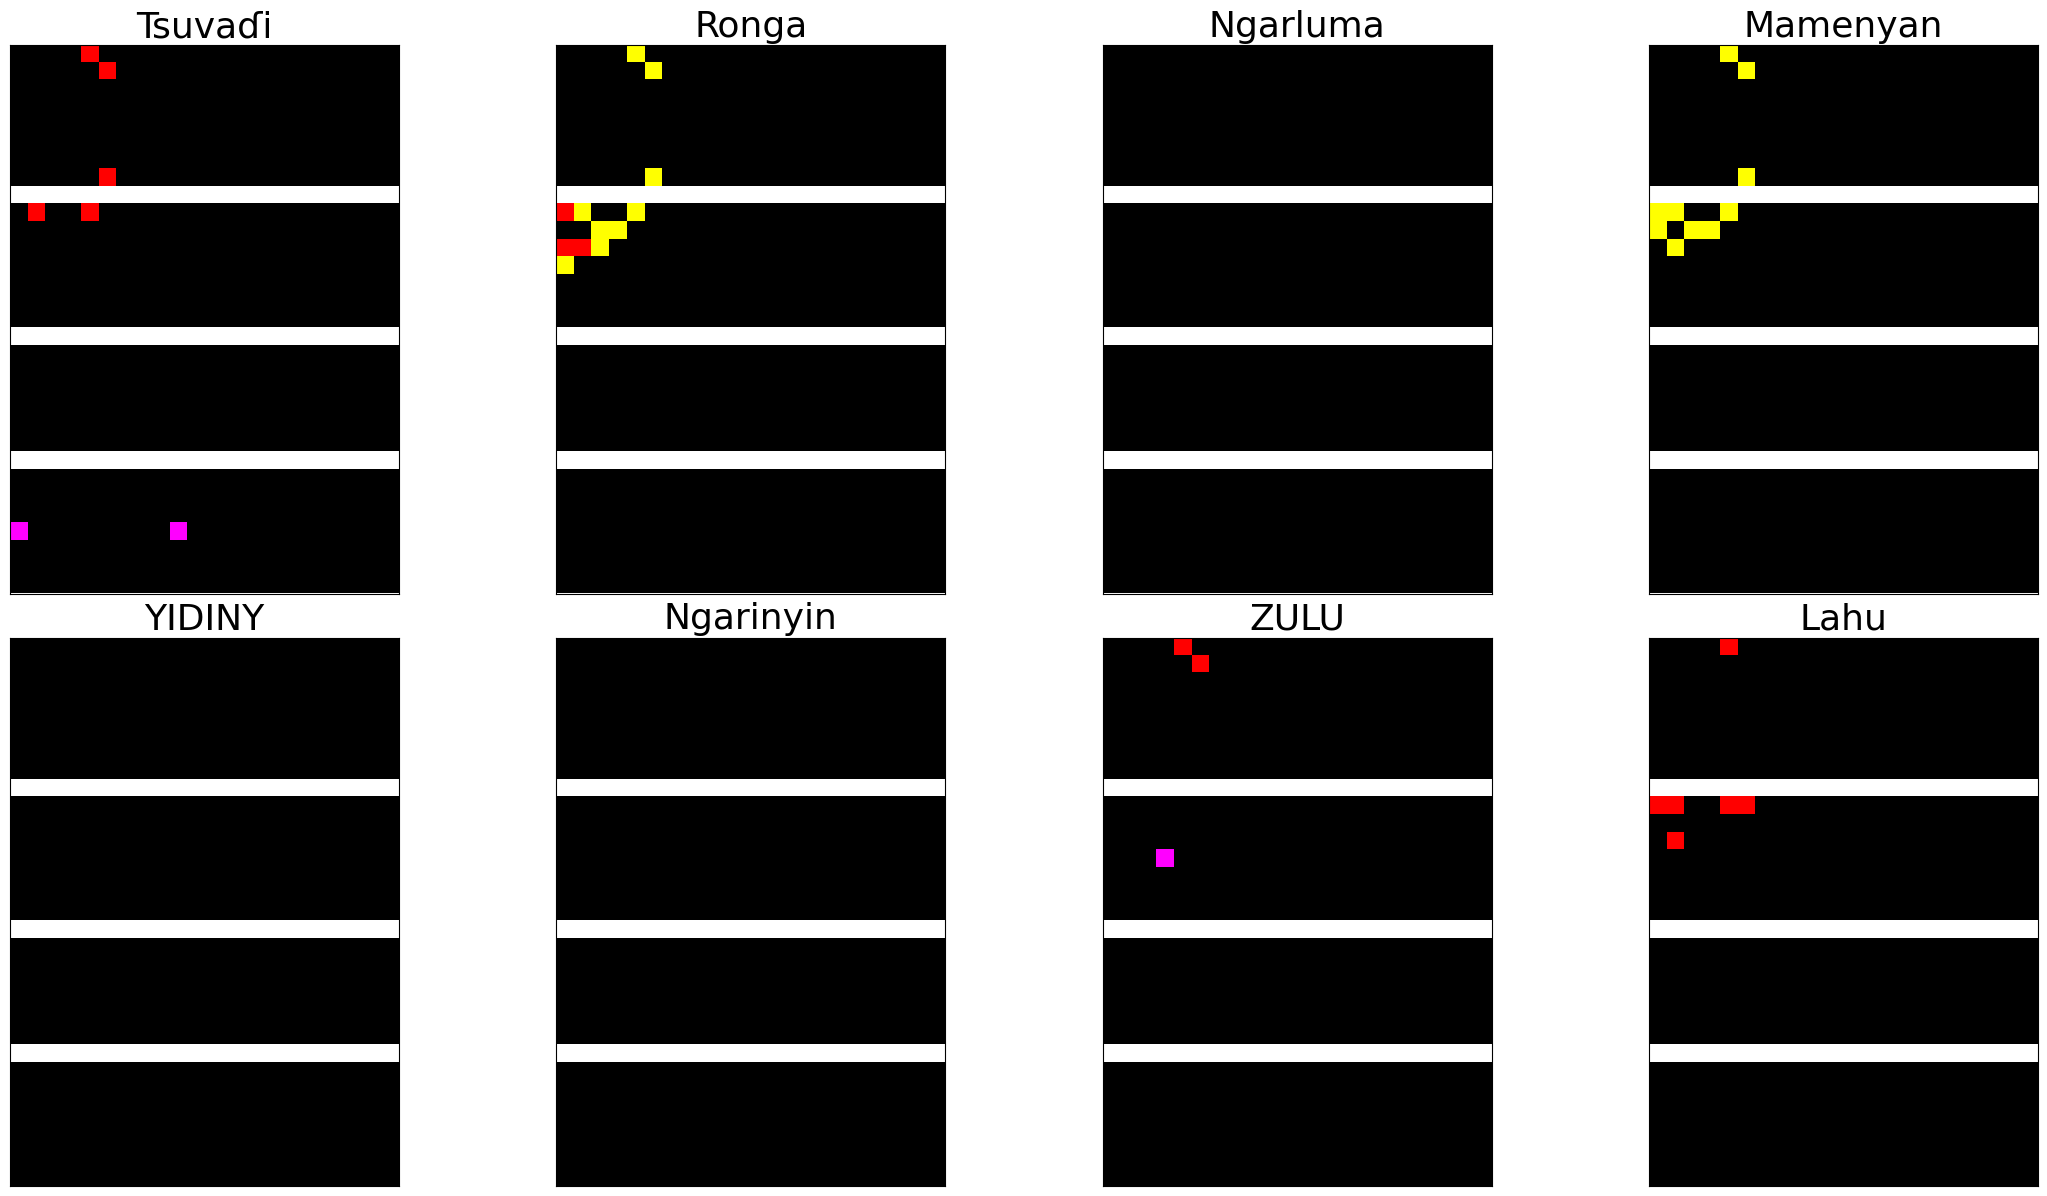

array([2187, 1853, 1613, 1369, 2381, 1609, 2481, 1233])

In [56]:
import matplotlib.pyplot as plt

r, c = 2, 4

gen = np.random.default_rng()
sample_indices = gen.choice(unique_names.size, r * c, replace=False)
samples = language_phonemes_selected[sample_indices]
sample_names = unique_names[sample_indices]

fig, axs = plt.subplots(r, c, figsize=(22, 12), linewidth=10)
fig.tight_layout()

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].set_title(sample_names[cnt][0:20], fontsize=26)
        enhanced = np.where(samples[cnt] > 0, np.ones(samples[cnt].shape), samples[cnt])
        axs[i, j].imshow(enhanced)
        axs[i, j].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        cnt += 1

plt.show()
sample_indices

In [ ]:
np.save("./data/language_phonemes.npy", language_phonemes_selected)

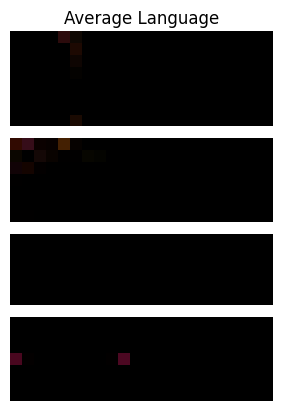

In [58]:
# what does an average language look like?
enhanced = np.where(
    language_phonemes_selected > 0,
    np.ones(language_phonemes_selected.shape),
    language_phonemes_selected,
)
mean_lang = np.mean(enhanced, axis=0)

fig = plt.imshow(
    mean_lang,
    cmap=plt.get_cmap("copper_r"),
    vmin=np.min(mean_lang),
    vmax=np.max(mean_lang),
)
plt.axis("off")
plt.title("Average Language")
plt.show()